In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
def load_boxoffice(path):
    # read safely with latin1 encoding
    df = pd.read_csv(path, encoding='latin1', low_memory=False)
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    
    # rename key fields
    rename_map = {
        'release_group':'title',
        'worldwide':'revenue_worldwide',
        'domestic':'revenue_domestic',
        'foreign':'revenue_foreign',
        'domestic_percent':'domestic_pct',
        'foreign_percent':'foreign_pct',
        'year':'release_year'
    }
    df = df.rename(columns=rename_map)

    # remove commas and convert numeric columns
    for col in ['revenue_worldwide','revenue_domestic','revenue_foreign']:
        df[col] = (
            df[col].astype(str)
                    .str.replace('[^0-9]', '', regex=True)
                    .replace('', np.nan)
                    .astype(float)
        )
    
    # clean percentages
    for col in ['domestic_pct','foreign_pct']:
        df[col] = (
            df[col].astype(str)
                    .str.replace('%','')
                    .replace('', np.nan)
                    .astype(float)
        )

    # clean titles
    df['title'] = df['title'].astype(str).str.strip()

    # fix year type
    df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce').astype('Int64')

    # remove empty rows (no revenue at all)
    df = df[(df['revenue_worldwide']>0) | (df['revenue_domestic']>0)]
    
    return df

In [2]:
import re

def parse_money_series(s):
    # strip everything except digits
    s = (s.astype(str)
          .str.replace(r'[^0-9]', '', regex=True)
          .replace({'': np.nan}))
    return s.astype(float)

def parse_percent_series(s, lt_policy="mid"):  
    """
    Parse percentage-like strings to float (0-100).
    Handles values like '39.40%', '100', '<0.1', '-', '—', ''.
    
    lt_policy:
      - 'mid' -> '<0.1' becomes 0.05  (midpoint; neutral)
      - 'ceil' -> '<0.1' becomes 0.1  (conservative upper bound)
      - 'zero' -> '<0.1' becomes 0.0  (lower bound)
      - 'nan' -> '<0.1' becomes NaN   (treat as unknown)
    """
    s = s.astype(str).str.strip()

    # normalize dashes and empties to NaN
    s = s.replace({'' : np.nan, '-' : np.nan, '—' : np.nan, '–' : np.nan})

    # remove trailing % and thousands commas/spaces
    s = s.str.replace('%', '', regex=False).str.replace(',', '', regex=False)

    # handle "<x" cases first
    mask_lt = s.str.startswith('<', na=False)
    if mask_lt.any():
        # extract the number after '<'
        nums = s.where(mask_lt).str.extract(r'<\s*([0-9]*\.?[0-9]+)', expand=False)
        if lt_policy == "mid":
            vals = pd.to_numeric(nums, errors='coerce') / 2.0
        elif lt_policy == "ceil":
            vals = pd.to_numeric(nums, errors='coerce')
        elif lt_policy == "zero":
            vals = 0.0
        else:  # 'nan'
            vals = np.nan
        s = s.mask(mask_lt, vals)

    # strip any stray non-numeric (just in case)
    s = s.str.replace(r'[^0-9\.]', '', regex=True).replace({'': np.nan})

    return pd.to_numeric(s, errors='coerce')

def load_boxoffice(path, lt_policy="mid"):
    df = pd.read_csv(path, encoding='latin1', low_memory=False)
    df.columns = (df.columns.str.strip()
                              .str.lower()
                              .str.replace(' ', '_'))

    rename_map = {
        'release_group':'title',
        'worldwide':'revenue_worldwide',
        'domestic':'revenue_domestic',
        'foreign':'revenue_foreign',
        'domestic_percent':'domestic_pct',
        'foreign_percent':'foreign_pct',
        'year':'release_year'
    }
    df = df.rename(columns=rename_map)

    # money columns
    for col in ['revenue_worldwide','revenue_domestic','revenue_foreign']:
        df[col] = parse_money_series(df[col])

    # percent columns (remain 0–100 floats)
    for col in ['domestic_pct','foreign_pct']:
        if col in df.columns:
            df[col] = parse_percent_series(df[col], lt_policy=lt_policy)

    # title/year cleanup
    df['title'] = df['title'].astype(str).str.strip()
    df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce').astype('Int64')

    # drop rows with zero across the board (likely junk)
    df = df[(df['revenue_worldwide'].fillna(0) > 0) | (df['revenue_domestic'].fillna(0) > 0)]

    return df


In [3]:
df_00s = load_boxoffice('D:/LinkedIn Features/Movie project/2000-2009 Movies Box Office Collection.csv',
                        lt_policy="mid")   # or "ceil"/"zero"/"nan"


In [18]:
df_00s.head()

,unnamed:_0,title,revenue_worldwide,revenue_domestic,domestic_pct,revenue_foreign,foreign_pct,release_year
0,0,Mission: Impossible II,546388108.0,215409889.0,39.4,330978219.0,60.6,2000
1,1,Gladiator,460583960.0,187705427.0,40.8,272878533.0,59.2,2000
2,2,Cast Away,429632142.0,233632142.0,54.4,196000000.0,45.6,2000
3,3,What Women Want,374111707.0,182811707.0,48.9,191300000.0,51.1,2000
4,4,Dinosaur,349822765.0,137748063.0,39.4,212074702.0,60.6,2000


In [4]:
df_1020s = load_boxoffice('D:/LinkedIn Features/Movie project/2010-2024 Movies Box Office Collection.csv',
                        lt_policy="mid")
df_1020s.head()

,rank,title,revenue_worldwide,revenue_domestic,domestic_pct,revenue_foreign,foreign_pct,release_year
0,0,Toy Story 3,1.066970e+09,415004880.0,38.9,651964823.0,61.1,2010
1,1,Alice in Wonderland,1.025467e+09,334191110.0,32.6,691276000.0,67.4,2010
2,2,Harry Potter and the Deathly Hallows: Part 1,9.602833e+08,295983305.0,30.8,664300000.0,69.2,2010
3,3,Inception,8.282587e+08,292576195.0,35.3,535682500.0,64.7,2010
4,4,Shrek Forever After,7.526009e+08,238736787.0,31.7,513864080.0,68.3,2010


In [5]:
df_2024 = load_boxoffice('D:/LinkedIn Features/Movie project/2024 Movies Box Office Collection.csv',
                        lt_policy="mid")
df_2024.head()

,unnamed:_0,title,revenue_worldwide,revenue_domestic,domestic_pct,revenue_foreign,foreign_pct,release_year
0,0,Inside Out 2,1.595984e+09,637852840.0,40.0,958130854.0,60.0,2024
1,1,Deadpool & Wolverine,1.043180e+09,506937007.0,48.6,536243178.0,51.4,2024
2,2,Despicable Me 4,8.085376e+08,332583715.0,41.1,475953856.0,58.9,2024
3,3,Dune: Part Two,7.118444e+08,282144358.0,39.6,429700000.0,60.4,2024
4,4,Godzilla x Kong: The New Empire,5.676500e+08,196350016.0,34.6,371300000.0,65.4,2024


In [45]:
#df_00s = load_boxoffice(r'D:/LinkedIn Features/Movie project/2000-2009 Movies Box Ofice Collection.csv')
#df_10s = load_boxoffice(r'D:/LinkedIn Features/Movie project/2010-2024 Movies Box Ofice Collection.csv')
df_24  = load_boxoffice(r'D:/LinkedIn Features/Movie project/2024 Movies Box Ofice Collection.csv')

In [8]:
df_00s = load_boxoffice(r'D:/LinkedIn Features/Movie project/2000-2009 Movies Box Office Collection.csv')
df_10s = load_boxoffice(r'D:/LinkedIn Features/Movie project/2010-2024 Movies Box Office Collection.csv')
df_24  = load_boxoffice(r'D:/LinkedIn Features/Movie project/2024 Movies Box Office Collection.csv')

# unify
df = pd.concat([df_00s, df_10s, df_24], ignore_index=True)

# simple key to dedupe if any overlap
df['title_key'] = (df['title'].astype(str)
                   .str.strip()
                   .str.replace(r'\s+', ' ', regex=True)
                   .str.lower())
df = df.drop_duplicates(subset=['title_key','release_year']).reset_index(drop=True)

# optional: sanity check % sums (flag rows that are far from 100)
pct_check = (df[['domestic_pct','foreign_pct']]
             .dropna()
             .assign(total=lambda x: x['domestic_pct'] + x['foreign_pct']))
bad_pct = df.loc[(df['domestic_pct'].notna()) & (df['foreign_pct'].notna())
                 & (np.abs(pct_check['total'] - 100) > 1.5)]
# If you want to auto-normalize small drift:
mask = (df['domestic_pct'].notna()) & (df['foreign_pct'].notna())
total = (df.loc[mask, 'domestic_pct'] + df.loc[mask, 'foreign_pct']).replace(0, np.nan)
df.loc[mask, 'domestic_pct'] = df.loc[mask, 'domestic_pct'] / total * 100
df.loc[mask, 'foreign_pct']  = df.loc[mask, 'foreign_pct']  / total * 100
df.drop(columns='unnamed:_0', inplace=True)
df.to_csv('boxoffice_clean_2000_2024.csv', index=False)


In [9]:
def event_period(y):
    if y <= 2001: return "Pre-9/11"
    elif 2002 <= y <= 2003: return "Post-9/11"
    elif 2007 <= y <= 2009: return "Financial Crisis"
    elif 2020 <= y <= 2021: return "Covid-19"
    elif y >= 2022: return "Recovery"
    else: return "Stable Growth"

df['event_period'] = df['release_year'].apply(event_period)
df.head()

,title,revenue_worldwide,revenue_domestic,domestic_pct,revenue_foreign,foreign_pct,release_year,rank,title_key,event_period
0,Mission: Impossible II,546388108.0,215409889.0,39.4,330978219.0,60.6,2000,NaN,mission: impossible ii,Pre-9/11
1,Gladiator,460583960.0,187705427.0,40.8,272878533.0,59.2,2000,NaN,gladiator,Pre-9/11
2,Cast Away,429632142.0,233632142.0,54.4,196000000.0,45.6,2000,NaN,cast away,Pre-9/11
3,What Women Want,374111707.0,182811707.0,48.9,191300000.0,51.1,2000,NaN,what women want,Pre-9/11
4,Dinosaur,349822765.0,137748063.0,39.4,212074702.0,60.6,2000,NaN,dinosaur,Pre-9/11


In [10]:
df.columns

Index(['title', 'revenue_worldwide', 'revenue_domestic', 'domestic_pct',
       'revenue_foreign', 'foreign_pct', 'release_year', 'rank', 'title_key',
       'event_period'],
      dtype='object')

In [51]:

df.head()

,title,revenue_worldwide,revenue_domestic,domestic_pct,revenue_foreign,foreign_pct,release_year,rank,title_key,event_period
0,Mission: Impossible II,546388108.0,215409889.0,39.4,330978219.0,60.6,2000,NaN,mission: impossible ii,Pre-9/11
1,Gladiator,460583960.0,187705427.0,40.8,272878533.0,59.2,2000,NaN,gladiator,Pre-9/11
2,Cast Away,429632142.0,233632142.0,54.4,196000000.0,45.6,2000,NaN,cast away,Pre-9/11
3,What Women Want,374111707.0,182811707.0,48.9,191300000.0,51.1,2000,NaN,what women want,Pre-9/11
4,Dinosaur,349822765.0,137748063.0,39.4,212074702.0,60.6,2000,NaN,dinosaur,Pre-9/11


In [52]:
df.sample(10)

,title,revenue_worldwide,revenue_domestic,domestic_pct,revenue_foreign,foreign_pct,release_year,rank,title_key,event_period
3198,Serial Teachers 2,25364150.0,0.0,0.0,25364150.0,100.0,2015,198.0,serial teachers 2,Stable Growth
4563,Table for Six,10138355.0,0.0,0.0,10138355.0,100.0,2022,164.0,table for six,Recovery
3915,Breakthrough,50444358.0,40713082.0,80.7,9731276.0,19.3,2019,115.0,breakthrough,Stable Growth
4502,Turning Red,21521622.0,1399001.0,6.5,20122621.0,93.5,2022,102.0,turning red,Recovery
131,I Dreamed of Africa,14400327.0,6651522.0,46.2,7748805.0,53.8,2000,NaN,i dreamed of africa,Pre-9/11
103,Boiler Room,28780255.0,16970581.0,59.0,11809674.0,41.0,2000,NaN,boiler room,Pre-9/11
3908,The Big Shot,56040681.0,0.0,0.0,56040681.0,100.0,2019,108.0,the big shot,Stable Growth
1804,2012,769679473.0,166112167.0,21.6,603567306.0,78.4,2009,NaN,2012,Financial Crisis
3451,Daddy's Home 2,180613180.0,104029443.0,57.6,76583737.0,42.4,2017,51.0,daddy's home 2,Stable Growth
2863,The Nut Job,120885527.0,64251541.0,53.2,56633986.0,46.8,2014,63.0,the nut job,Stable Growth


In [55]:
df['release_year'].sort_values().unique()

<IntegerArray>
[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Length: 25, dtype: Int64

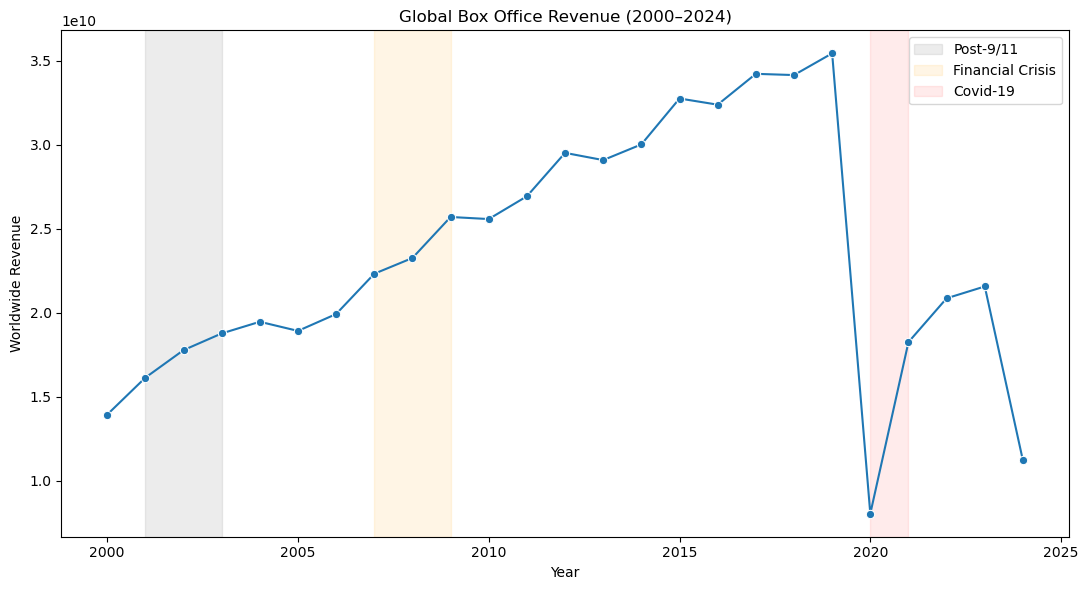

In [11]:
year_rev = (df.groupby('release_year', as_index=False)['revenue_worldwide'].sum())


plt.figure(figsize=(11,6))
sns.lineplot(data=year_rev, x='release_year', y='revenue_worldwide', marker='o')
plt.title('Global Box Office Revenue (2000–2024)')
plt.xlabel('Year'); plt.ylabel('Worldwide Revenue')

# shade events
plt.axvspan(2001, 2003, color='grey', alpha=0.15, label='Post-9/11')
plt.axvspan(2007, 2009, color='orange', alpha=0.10, label='Financial Crisis')
plt.axvspan(2020, 2021, color='red',   alpha=0.08, label='Covid-19')
plt.legend()
plt.tight_layout()
#plt.show()
plt.savefig('globalboxofficerevenue.png', dpi=200, bbox_inches='tight')

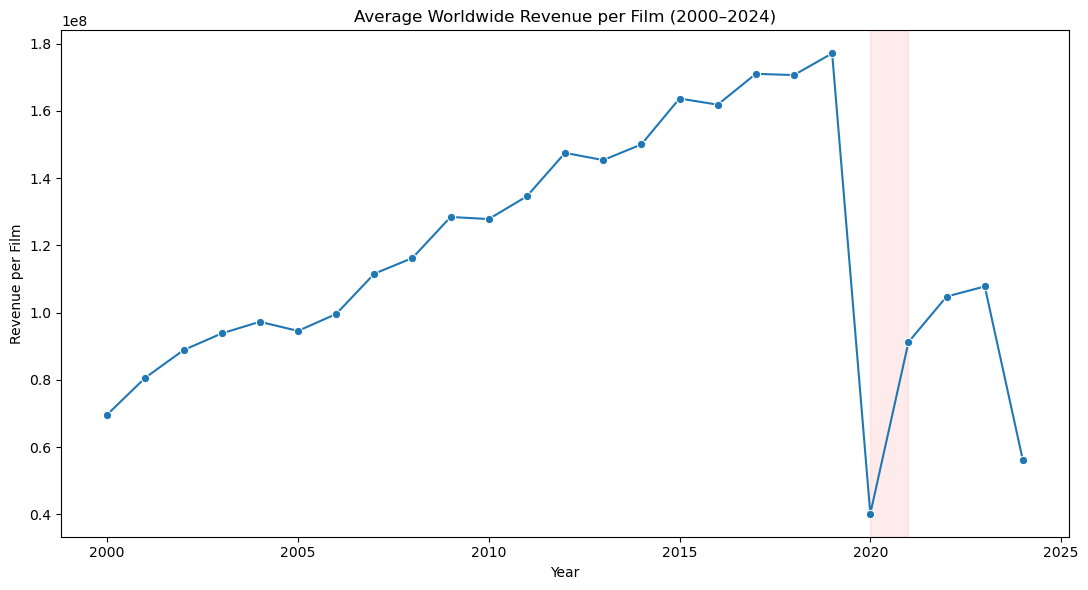

In [74]:
titles_per_year = df.groupby('release_year')['title'].nunique().reset_index(name='n_titles')
avg_rev = year_rev.merge(titles_per_year, on='release_year', how='left')
avg_rev['revenue_per_film'] = avg_rev['revenue_worldwide'] / avg_rev['n_titles']

plt.figure(figsize=(11,6))
sns.lineplot(data=avg_rev, x='release_year', y='revenue_per_film', marker='o')
plt.title('Average Worldwide Revenue per Film (2000–2024)')
plt.xlabel('Year'); plt.ylabel('Revenue per Film')
plt.axvspan(2020, 2021, color='red', alpha=0.08)
plt.tight_layout()
#plt.show()
plt.savefig('avgworldwiderevenue.png', dpi=200, bbox_inches='tight')


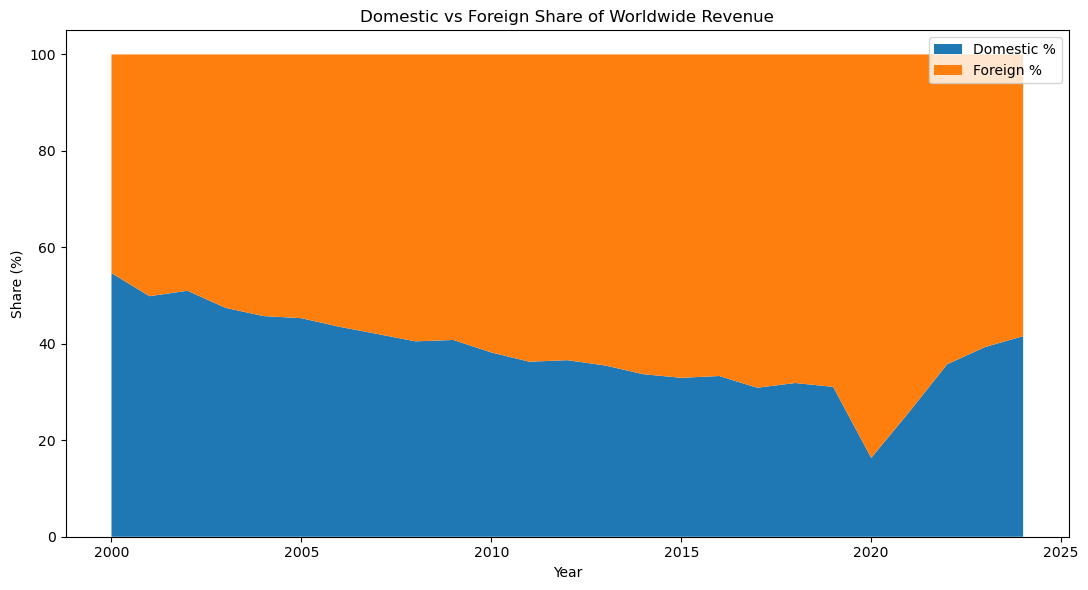

In [12]:
year_parts = (df.groupby('release_year', as_index=False)
                .agg(domestic=('revenue_domestic','sum'),
                     foreign=('revenue_foreign','sum')))
year_parts['total'] = year_parts['domestic'] + year_parts['foreign']
year_parts[['domestic','foreign']] = year_parts[['domestic','foreign']].div(year_parts['total'], axis=0)*100

plt.figure(figsize=(11,6))
plt.stackplot(year_parts['release_year'],
              year_parts['domestic'], year_parts['foreign'],
              labels=['Domestic %','Foreign %'])
plt.title('Domestic vs Foreign Share of Worldwide Revenue')
plt.xlabel('Year'); plt.ylabel('Share (%)')
plt.legend(loc='upper right')
plt.tight_layout()
#plt.show()
plt.savefig('domvsforrevenue.png', dpi=200, bbox_inches='tight')


In [64]:
df[df['title'].str.contains('Avengers')][['title','revenue_worldwide', 'revenue_domestic','revenue_foreign','release_year']]

,title,revenue_worldwide,revenue_domestic,revenue_foreign,release_year
2400,The Avengers,1.518813e+09,623357910.0,8.954551e+08,2012
3003,Avengers: Age of Ultron,1.402806e+09,459005868.0,9.438000e+08,2015
3600,Avengers: Infinity War,2.048360e+09,678815482.0,1.369544e+09,2018
3800,Avengers: Endgame,2.799439e+09,858373000.0,1.941066e+09,2019


In [62]:
df.columns

Index(['title', 'revenue_worldwide', 'revenue_domestic', 'domestic_pct',
       'revenue_foreign', 'foreign_pct', 'release_year', 'rank', 'title_key',
       'event_period'],
      dtype='object')

In [13]:
top_100 = df[['title','revenue_worldwide', 'revenue_domestic','revenue_foreign','release_year']].sort_values(by=['revenue_worldwide','release_year'], 
                                                                                                   ascending= False).head(100)


top_100['title'].unique()

array(['Avengers: Endgame', 'Avatar', 'Avatar: The Way of Water',
       'Star Wars: Episode VII 0 The Force Awakens',
       'Avengers: Infinity War', 'Spider0Man: No Way Home',
       'Jurassic World', 'The Lion King', 'Inside Out 2', 'The Avengers',
       'Furious 7', 'Top Gun: Maverick', 'Frozen II', 'Barbie',
       'Avengers: Age of Ultron', 'The Super Mario Bros. Movie',
       'Black Panther', 'Harry Potter and the Deathly Hallows: Part 2',
       'Star Wars: Episode VIII 0 The Last Jedi',
       'Jurassic World: Fallen Kingdom', 'Frozen', 'Beauty and the Beast',
       'Incredibles 2', 'The Fate of the Furious', 'Iron Man 3',
       'Minions', 'Captain America: Civil War', 'Aquaman',
       'The Lord of the Rings: The Return of the King',
       'Spider0Man: Far from Home', 'Captain Marvel',
       'Transformers: Dark of the Moon', 'Skyfall',
       'Transformers: Age of Extinction', 'The Dark Knight Rises',
       'Joker', 'Star Wars: Episode IX 0 The Rise of Skywalker',
   

In [14]:
top_100.to_csv('top_100_highest_rev.csv', index=False)
top_100.sample(50)

,title,revenue_worldwide,revenue_domestic,revenue_foreign,release_year
2202,Pirates of the Caribbean: On Stranger Tides,1.045714e+09,241071802.0,8.046420e+08,2011
3002,Furious 7,1.515048e+09,353007020.0,1.162041e+09,2015
2400,The Avengers,1.518813e+09,623357910.0,8.954551e+08,2012
2801,The Hobbit: The Battle of the Five Armies,9.560198e+08,255119788.0,7.009000e+08,2014
4202,"Hi, Mom",8.220098e+08,0.0,8.220098e+08,2021
2003,Inception,8.282587e+08,292576195.0,5.356825e+08,2010
2404,Ice Age: Continental Drift,8.772448e+08,161321843.0,7.159229e+08,2012
400,The Lord of the Rings: The Two Towers,9.230152e+08,339789881.0,5.832254e+08,2002
1200,Pirates of the Caribbean: Dead Man's Chest,1.066180e+09,423315812.0,6.428639e+08,2006
2405,The Twilight Saga: Breaking Dawn 0 Part 2,8.297468e+08,292324737.0,5.374221e+08,2012


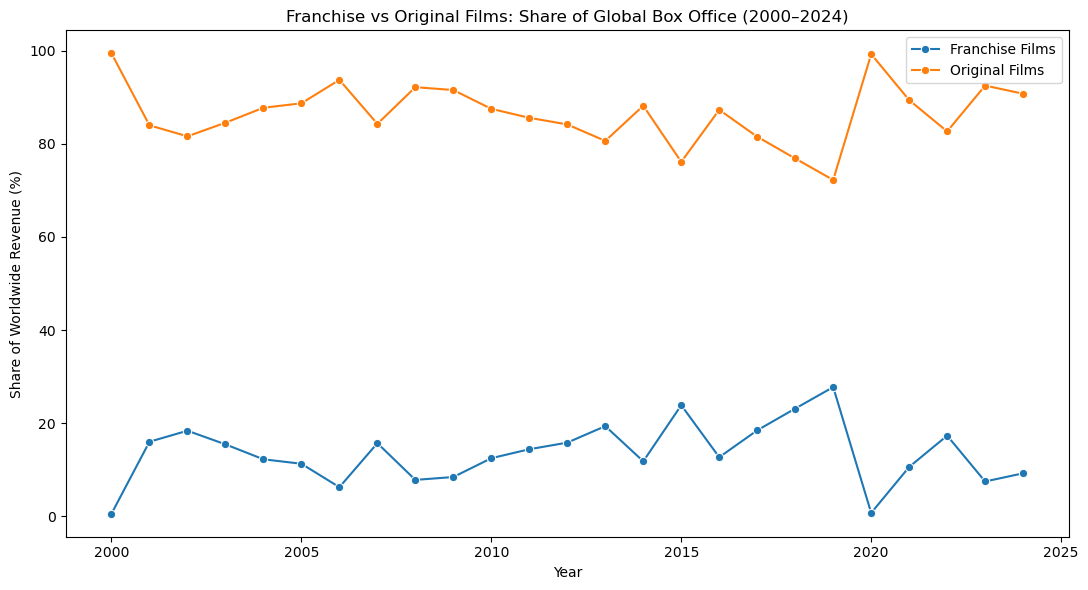

In [15]:
def is_franchise(title):
    keywords = ['Avengers','Star Wars','Frozen','Jurassic','Minions','Toy Story','Incredibles',
                'Iron Man','Captain','Spider','Batman','Dark Knight','Hobbit','Harry Potter',
                'Transformers','Despicable','Furious','Pirates','Finding','Black Panther','Aquaman','The Lord of the Rings']
    return any(k.lower() in title.lower() for k in keywords)

df['is_franchise'] = df['title'].apply(is_franchise)

franchise_share = (
    df.groupby(['release_year','is_franchise'])['revenue_worldwide']
      .sum().reset_index()
)

# calculate yearly % share
year_total = franchise_share.groupby('release_year')['revenue_worldwide'].transform('sum')
franchise_share['share_pct'] = franchise_share['revenue_worldwide'] / year_total * 100

# plot
#import seaborn as sns, matplotlib.pyplot as plt

plt.figure(figsize=(11,6))
sns.lineplot(data=franchise_share[franchise_share['is_franchise']], 
             x='release_year', y='share_pct', marker='o', label='Franchise Films')
sns.lineplot(data=franchise_share[~franchise_share['is_franchise']], 
             x='release_year', y='share_pct', marker='o', label='Original Films')
plt.title('Franchise vs Original Films: Share of Global Box Office (2000–2024)')
plt.ylabel('Share of Worldwide Revenue (%)')
plt.xlabel('Year')
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
df_top = pd.read_csv("top_100_highest_rev.csv")
df_top.info()
df_top.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              100 non-null    object 
 1   revenue_worldwide  100 non-null    float64
 2   revenue_domestic   100 non-null    float64
 3   revenue_foreign    100 non-null    float64
 4   release_year       100 non-null    int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 4.0+ KB


,title,revenue_worldwide,revenue_domestic,revenue_foreign,release_year
0,Avengers: Endgame,2.799439e+09,858373000.0,1.941066e+09,2019
1,Avatar,2.743578e+09,749766139.0,1.993811e+09,2009
2,Avatar: The Way of Water,2.320250e+09,684075767.0,1.636175e+09,2022
3,Star Wars: Episode VII 0 The Force Awakens,2.068224e+09,936662225.0,1.131561e+09,2015
4,Avengers: Infinity War,2.048360e+09,678815482.0,1.369544e+09,2018
5,Spider0Man: No Way Home,1.912234e+09,804793477.0,1.107440e+09,2021
6,Jurassic World,1.670401e+09,652270625.0,1.018130e+09,2015
7,The Lion King,1.656943e+09,543638043.0,1.113305e+09,2019
8,Inside Out 2,1.595984e+09,637852840.0,9.581309e+08,2024
9,The Avengers,1.518813e+09,623357910.0,8.954551e+08,2012


In [26]:
df.loc[df['title'].str.contains('Iron')]

,title,revenue_worldwide,revenue_domestic,domestic_pct,revenue_foreign,foreign_pct,release_year,rank,title_key,event_period,is_franchise
348,Iron Monkey,1.469490e+07,14694904.0,100.0,0.0,0.0,2001,NaN,iron monkey,Pre-9/11,False
1500,The Irony of Fate 2,5.563974e+07,0.0,0.0,55639741.0,100.0,2007,NaN,the irony of fate 2,Financial Crisis,False
1607,Iron Man,5.853662e+08,318604126.0,54.4,266762121.0,45.6,2008,NaN,iron man,Financial Crisis,True
2006,Iron Man 2,6.239333e+08,312433331.0,50.1,311500000.0,49.9,2010,6.0,iron man 2,Stable Growth,True
2266,The Iron Lady,1.158907e+08,30017992.0,25.9,85872707.0,74.1,2011,66.0,the iron lady,Stable Growth,False
2601,Iron Man 3,1.214811e+09,409013994.0,33.7,805797258.0,66.3,2013,1.0,iron man 3,Stable Growth,True
4647,Detective Conan: Black Iron Submarine,1.067718e+08,0.0,0.0,106771806.0,100.0,2023,48.0,detective conan: black iron submarine,Recovery,False
4679,The Iron Claw,4.520254e+07,35070296.0,77.6,10132245.0,22.4,2023,80.0,the iron claw,Recovery,False


In [34]:
def tag_franchise(title):
    franchises = {
        # Major universes
        'Avengers': 'Marvel / Avengers',
        'Captain America': 'Marvel / Avengers',
        'Captain Marvel' : 'Marvel / Avengers',
        'Iron Man': 'Marvel / Avengers',
        'Black Widow' : 'Marvel / Avengers',
        'Black Panther': 'Marvel / Avengers',
        'Spider': 'Marvel / Avengers',
        'Star Wars': 'Star Wars',
        'Rogue One' :'Star Wars' ,
        'Batman': 'DC',
        'Justice League': 'DC',
        'Wonder Woman' : 'DC',
        'The Dark Knight' : 'DC',
        'Joker' : 'DC',
        'Aquaman' : 'DC',
        'Deadpool & Wolverine' : 'Marvel / Avengers',
        'Doctor Strange' :'Marvel / Avengers',
        'Thor' : 'Marvel / Avengers',
        'Thor: The Dark World' : 'Marvel / Avengers',
        'Guardians of the Galaxy' :'Marvel / Avengers',
        'Venom' : 'Marvel / Avengers',

        # Fantasy epics
        'Lord of the Rings': 'Lord of the Rings / Hobbit',
        'Hobbit': 'Lord of the Rings / Hobbit',
        'Harry Potter': 'Harry Potter / Wizarding World',
        'Fantastic Beasts': 'Harry Potter / Wizarding World',

        # Action franchises
        'Fast': 'Fast & Furious',
        'Furious': 'Fast & Furious',
        'The Fate of the Furious': 'Fast & Furious',
        'Jurassic': 'Jurassic',
        'Transformers': 'Transformers',
        'Mission': 'Mission: Impossible',
        'Skyfall' : 'James Bond',
        'Spectre' : 'James Bond',
        'Bond': 'James Bond',

        # Animation powerhouses
        'Frozen': 'Frozen',
        'Toy Story': 'Toy Story',
        'Incredibles': 'Incredibles',
        'Despicable': 'Despicable Me / Minions',
        'Minions': 'Despicable Me / Minions',
        'Finding Dory': 'Pixar Sequel',
        'Finding Nemo' : 'Finding Nemo',
        'Ice Age' : 'Pixar Sequel',
        'Inside Out': 'Pixar Sequel',
        'Coco': 'Original',
        'Zootopia': 'Original',

        # Disney remakes & studios
        'Beauty and the Beast': 'Disney Remake',
        'Lion King': 'Disney Remake',
        'Aladdin': 'Disney Remake',
        'The Jungle Book' : 'Disney Remake',
        'Little Mermaid': 'Disney Remake',

        # Other universes
        'Avatar': 'Avatar',
        'The Hunger Games' : 'The Hunger Games',
        'Super Mario': 'Nintendo / Mario',
        'Jumanji' : 'Jumanji',
        'Pirates' : 'Pirates of the Caribbean',
        'The Twilight Saga' : 'The Twilight Saga',
        'Shrek' : 'Shrek',
        'Top Gun': 'Legacy Sequel',
    }

    for key, val in franchises.items():
        if key.lower() in title.lower():
            return val
    return "Original"




In [28]:
df_top['title'].sort_values().unique()

array(['Aladdin', 'Alice in Wonderland', 'Aquaman', 'Avatar',
       'Avatar: The Way of Water', 'Avengers: Age of Ultron',
       'Avengers: Endgame', 'Avengers: Infinity War', 'Barbie',
       'Batman v Superman: Dawn of Justice', 'Beauty and the Beast',
       'Black Panther', 'Black Panther: Wakanda Forever',
       'Bohemian Rhapsody', 'Captain America: Civil War',
       'Captain Marvel', 'Coco', 'Deadpool & Wolverine',
       'Despicable Me 2', 'Despicable Me 3', 'Despicable Me 4',
       'Doctor Strange in the Multiverse of Madness',
       'Fantastic Beasts and Where to Find Them', 'Finding Dory',
       'Finding Nemo', 'Frozen', 'Frozen II', 'Furious 7',
       'Guardians of the Galaxy Vol. 2', 'Guardians of the Galaxy Vol. 3',
       'Harry Potter and the Chamber of Secrets',
       'Harry Potter and the Deathly Hallows: Part 1',
       'Harry Potter and the Deathly Hallows: Part 2',
       'Harry Potter and the Goblet of Fire',
       'Harry Potter and the Half0Blood Prince

In [84]:
df_top.head()

,title,revenue_worldwide,revenue_domestic,revenue_foreign,release_year,franchise
0,Avengers: Endgame,2.799439e+09,858373000.0,1.941066e+09,2019,Marvel / Avengers
1,Avatar,2.743578e+09,749766139.0,1.993811e+09,2009,Avatar
2,Avatar: The Way of Water,2.320250e+09,684075767.0,1.636175e+09,2022,Avatar
3,Star Wars: Episode VII 0 The Force Awakens,2.068224e+09,936662225.0,1.131561e+09,2015,Star Wars
4,Avengers: Infinity War,2.048360e+09,678815482.0,1.369544e+09,2018,Marvel / Avengers


In [35]:
df_top['franchise'] = df_top['title'].apply(tag_franchise)
summary = (
    df_top.groupby('franchise')['revenue_worldwide']
    .agg(['count', 'sum'])
    .sort_values(by='sum', ascending=False)
)
summary['share_pct'] = summary['sum'] / summary['sum'].sum() * 100
summary.head(15)

,count,sum,share_pct
franchise,,,
Marvel / Avengers,20,2.453127e+10,21.922270
Original,11,1.048747e+10,9.372080
Harry Potter / Wizarding World,9,8.539016e+09,7.630856
Star Wars,5,6.399318e+09,5.718724
DC,6,6.016821e+09,5.376907
Lord of the Rings / Hobbit,6,5.863494e+09,5.239887
Pixar Sequel,5,5.246781e+09,4.688764
Avatar,2,5.063828e+09,4.525269
Disney Remake,4,4.937709e+09,4.412563


In [36]:
summary = (df_top.groupby('franchise')['revenue_worldwide']
             .agg(['count','sum'])
             .sort_values(by='sum', ascending=False))
summary['share_pct'] = summary['sum'] / summary['sum'].sum() * 100
summary.head(15)


,count,sum,share_pct
franchise,,,
Marvel / Avengers,20,2.453127e+10,21.922270
Original,11,1.048747e+10,9.372080
Harry Potter / Wizarding World,9,8.539016e+09,7.630856
Star Wars,5,6.399318e+09,5.718724
DC,6,6.016821e+09,5.376907
Lord of the Rings / Hobbit,6,5.863494e+09,5.239887
Pixar Sequel,5,5.246781e+09,4.688764
Avatar,2,5.063828e+09,4.525269
Disney Remake,4,4.937709e+09,4.412563


C:\Users\dirtd\AppData\Local\Temp\ipykernel_31416\2121679958.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary.head(10).reset_index(),


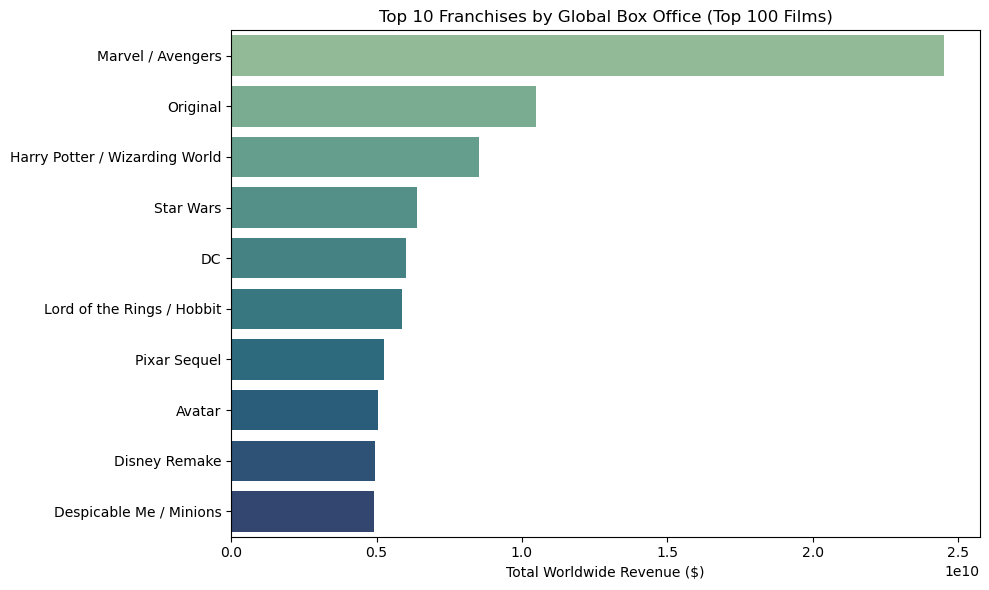

In [37]:
plt.figure(figsize=(10,6))
sns.barplot(data=summary.head(10).reset_index(),
            y='franchise', x='sum', palette='crest')
plt.title('Top 10 Franchises by Global Box Office (Top 100 Films)')
plt.xlabel('Total Worldwide Revenue ($)')
plt.ylabel('')
plt.tight_layout()
plt.show()


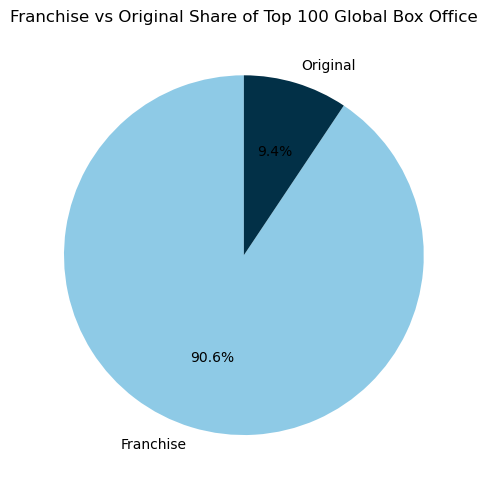

In [38]:
share = df_top.assign(type=np.where(df_top['franchise']=='Original','Original','Franchise'))
share = share.groupby('type')['revenue_worldwide'].sum()
share.plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(5,5),
           colors=['#8ecae6','#023047'], ylabel='')
plt.title('Franchise vs Original Share of Top 100 Global Box Office')
plt.tight_layout()
plt.show()


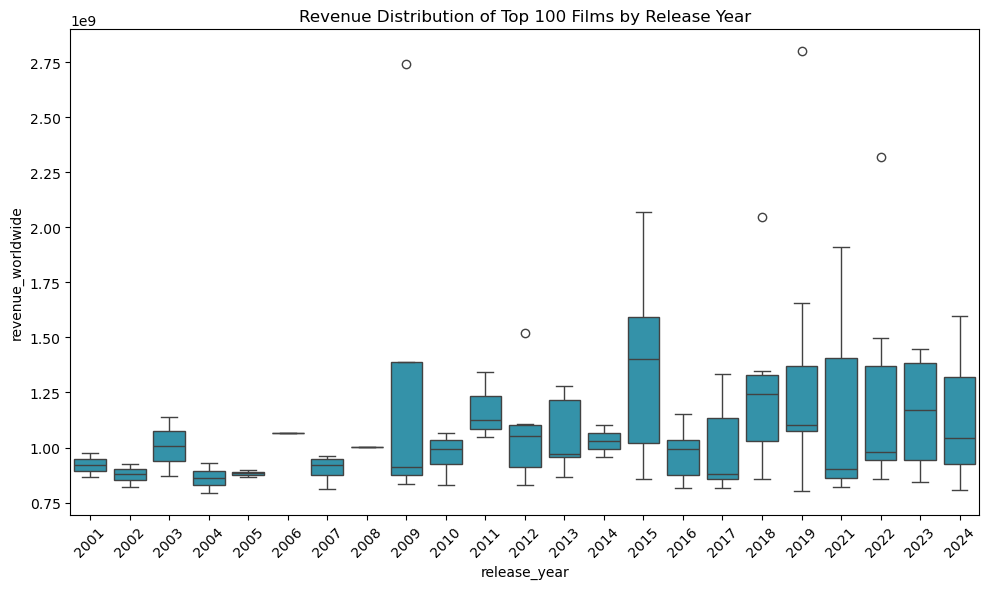

In [39]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_top, x='release_year', y='revenue_worldwide', color='#219ebc')
plt.title('Revenue Distribution of Top 100 Films by Release Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [40]:
df_top['is_franchise'] = df_top['franchise'].apply(lambda x: 'Franchise' if x != 'Original' else 'Original')

avg_rev = (
    df_top.groupby(['release_year','is_franchise'])['revenue_worldwide']
    .mean()
    .reset_index()
)
df_top

,title,revenue_worldwide,revenue_domestic,revenue_foreign,release_year,franchise,is_franchise
0,Avengers: Endgame,2.799439e+09,858373000.0,1.941066e+09,2019,Marvel / Avengers,Franchise
1,Avatar,2.743578e+09,749766139.0,1.993811e+09,2009,Avatar,Franchise
2,Avatar: The Way of Water,2.320250e+09,684075767.0,1.636175e+09,2022,Avatar,Franchise
3,Star Wars: Episode VII 0 The Force Awakens,2.068224e+09,936662225.0,1.131561e+09,2015,Star Wars,Franchise
4,Avengers: Infinity War,2.048360e+09,678815482.0,1.369544e+09,2018,Marvel / Avengers,Franchise
...,...,...,...,...,...,...,...
95,Coco,8.146412e+08,210460015.0,6.041812e+08,2017,Original,Original
96,Shrek the Third,8.133674e+08,322719944.0,4.906474e+08,2007,Shrek,Franchise
97,Despicable Me 4,8.085376e+08,332583715.0,4.759539e+08,2024,Despicable Me / Minions,Franchise
98,Jumanji: The Next Level,8.016939e+08,320314960.0,4.813790e+08,2019,Jumanji,Franchise


In [41]:
df_top[df_top['is_franchise'] == 'Original'][['title','is_franchise']]

,title,is_franchise
13,Barbie,Original
46,Alice in Wonderland,Original
47,Zootopia,Original
51,Oppenheimer,Original
66,Bohemian Rhapsody,Original
67,The Battle at Lake Changjin,Original
75,The Secret Life of Pets,Original
78,Wolf Warrior 2,Original
90,Inception,Original
92,"Hi, Mom",Original


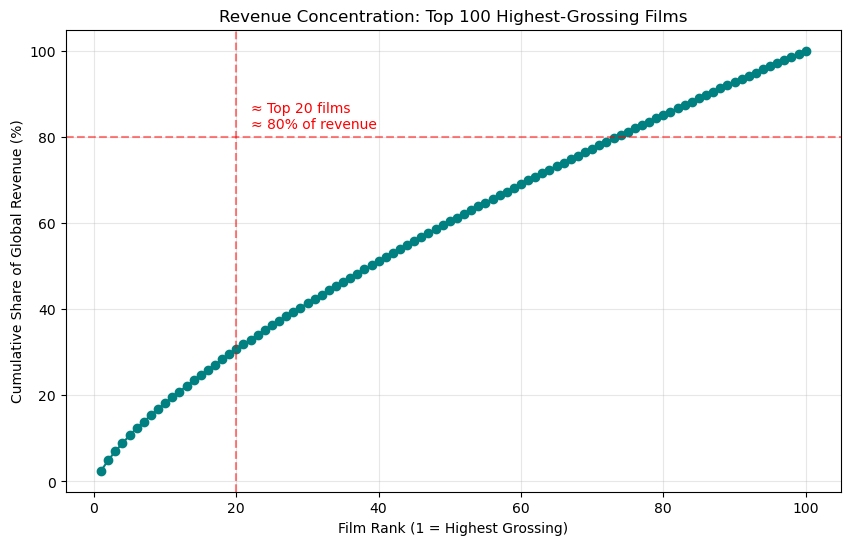

In [42]:
df_conc = (
    df_top.sort_values(by='revenue_worldwide', ascending=False)
           .assign(cum_revenue=lambda x: x['revenue_worldwide'].cumsum(),
                   share=lambda x: x['revenue_worldwide'] / x['revenue_worldwide'].sum(),
                   cum_share=lambda x: x['share'].cumsum(),
                   rank=lambda x: np.arange(1, len(x)+1))
)
plt.figure(figsize=(10,6))
plt.plot(df_conc['rank'], df_conc['cum_share']*100, marker='o', color='teal')
plt.axhline(80, color='r', linestyle='--', alpha=0.5)
plt.axvline(20, color='r', linestyle='--', alpha=0.5)
plt.text(22, 82, "≈ Top 20 films\n≈ 80% of revenue", color='r')

plt.title("Revenue Concentration: Top 100 Highest-Grossing Films")
plt.xlabel("Film Rank (1 = Highest Grossing)")
plt.ylabel("Cumulative Share of Global Revenue (%)")
plt.grid(alpha=0.3)
plt.show()

In [129]:
df.head()

,title,revenue_worldwide,revenue_domestic,domestic_pct,revenue_foreign,foreign_pct,release_year,rank,title_key,event_period,is_franchise
0,Mission: Impossible II,546388108.0,215409889.0,39.4,330978219.0,60.6,2000,NaN,mission: impossible ii,Pre-9/11,False
1,Gladiator,460583960.0,187705427.0,40.8,272878533.0,59.2,2000,NaN,gladiator,Pre-9/11,False
2,Cast Away,429632142.0,233632142.0,54.4,196000000.0,45.6,2000,NaN,cast away,Pre-9/11,False
3,What Women Want,374111707.0,182811707.0,48.9,191300000.0,51.1,2000,NaN,what women want,Pre-9/11,False
4,Dinosaur,349822765.0,137748063.0,39.4,212074702.0,60.6,2000,NaN,dinosaur,Pre-9/11,False


In [139]:
df[df['release_year'] >= 2020]['title'].sort_values().unique() #'Post-9/11'

array(['###############################################################################################################################################################################################################################################################',
       '#Alive', '10 Days with Dad', '10 Lives', '100% Wolf',
       '12.12: The Day', '18Ã\x972 Beyond Youthful Days', '1921',
       '2024 Oscar Nominated Short Films: Documentary', '30 jours max',
       '3391 Kilometres', '365 Days', '65', '777 Charlie', '80 for Brady',
       '99.9 Criminal Lawyer: The Movie', 'A Guilty Conscience',
       'A Haunting in Venice', 'A Little Red Flower',
       'A Little Something Extra', 'A Man Called Otto',
       'A Million Minutes', 'A Moroccan Affair', 'A Piece of Cake',
       'A Quiet Place Part II', 'A Quiet Place: Day One',
       "A Smile Doesn't Lie", 'A Strange House', "A Writer's Odyssey",
       'AI Amok', 'Aavesham', 'Abigail', 'About My Father',
       'Abudeka Is Back', '

In [43]:
mcu = ['Black Panther 2020 Re0release', 'Black Panther: Wakanda Forever','Black Widow','Ant0Man and the Wasp: Quantumania',
'Deadpool & Wolverine','Doctor Strange in the Multiverse of Madness','Eternals','Guardians of the Galaxy Vol. 3','Shang0Chi and the Legend of the Ten Rings',
'Spider0Man: No Way Home','Spider0Man: No Way Home 2022 Re0release','The Marvels','Thor: Love and Thunder']

In [145]:
df[df['title'].isin(mcu)][['title', 'revenue_worldwide', 'revenue_domestic', 'domestic_pct',
       'revenue_foreign', 'foreign_pct', 'release_year', 'event_period']]

,title,revenue_worldwide,revenue_domestic,domestic_pct,revenue_foreign,foreign_pct,release_year,event_period
4057,Black Panther 2020 Re0release,2.804657e+07,367000.0,1.302605,2.763519e+07,98.697395,2020,Covid-19
4200,Spider0Man: No Way Home,1.912234e+09,804793477.0,42.100000,1.107440e+09,57.900000,2021,Covid-19
4208,Shang0Chi and the Legend of the Ten Rings,4.322433e+08,224543292.0,51.900000,2.077000e+08,48.100000,2021,Covid-19
4210,Eternals,4.020649e+08,164870234.0,41.000000,2.371947e+08,59.000000,2021,Covid-19
4212,Black Widow,3.797517e+08,183651655.0,48.400000,1.961000e+08,51.600000,2021,Covid-19
4403,Doctor Strange in the Multiverse of Madness,9.557758e+08,411331607.0,43.000000,5.444442e+08,57.000000,2022,Recovery
4405,Black Panther: Wakanda Forever,8.592088e+08,453829060.0,52.800000,4.053798e+08,47.200000,2022,Recovery
4407,Thor: Love and Thunder,7.609281e+08,343256830.0,45.100000,4.176713e+08,54.900000,2022,Recovery
4570,Spider0Man: No Way Home 2022 Re0release,9.613518e+06,9321593.0,97.000000,2.919250e+05,3.000000,2022,Recovery
4602,Guardians of the Galaxy Vol. 3,8.455558e+08,358995815.0,42.500000,4.865600e+08,57.500000,2023,Recovery


In [140]:
df.columns

Index(['title', 'revenue_worldwide', 'revenue_domestic', 'domestic_pct',
       'revenue_foreign', 'foreign_pct', 'release_year', 'rank', 'title_key',
       'event_period', 'is_franchise'],
      dtype='object')

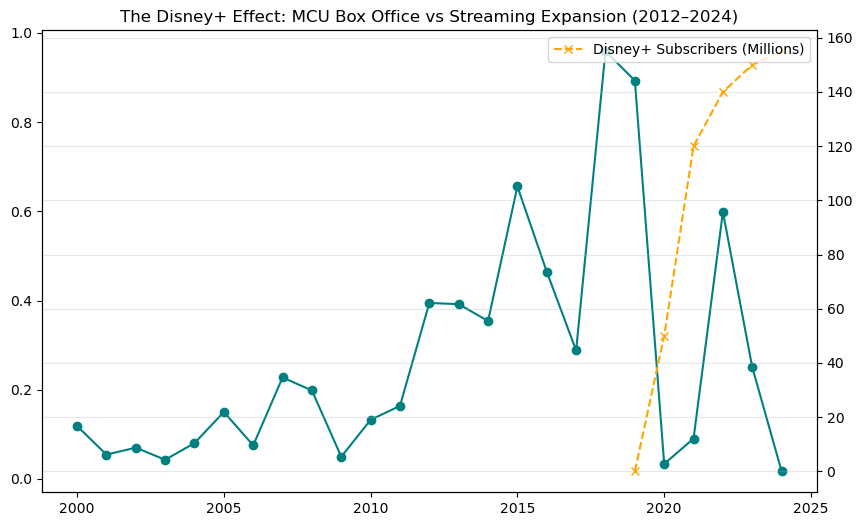

In [44]:


# MCU revenue trend
mcu = df[df['title'].str.contains('Avengers|Thor|Iron Man|Doctor Strange|Black Panther|Ant|Captain|Guardians|Marvel', case=False)]
mcu_trend = mcu.groupby('release_year')['revenue_worldwide'].mean().reset_index()

# Disney+ timeline points
disney_plus = {
    2019: 0,    # Launch
    2020: 50,   # early growth (approx millions subs)
    2021: 120,
    2022: 140,
    2023: 150,
    2024: 155
}

plt.figure(figsize=(10,6))

# MCU line
plt.plot(mcu_trend['release_year'], mcu_trend['revenue_worldwide']/1e9, color='teal', marker='o', label='Avg MCU Film Revenue ($B)')

# Disney+ overlay (secondary axis)
ax2 = plt.gca().twinx()
ax2.plot(list(disney_plus.keys()), list(disney_plus.values()), color='orange', linestyle='--', marker='x', label='Disney+ Subscribers (Millions)')

# Styling
plt.title("The Disney+ Effect: MCU Box Office vs Streaming Expansion (2012–2024)")
plt.xlabel("Year")
plt.grid(alpha=0.3)
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


In [45]:
import numpy as np

df = df.copy()
# 1) sum check
df['sum_check'] = (df['revenue_domestic'].fillna(0) + df['revenue_foreign'].fillna(0)) - df['revenue_worldwide'].fillna(0)
sum_ok = (df['sum_check'].abs() <= 1e6).mean()  # within $1M tolerance
# 2) pct check
df['pct_check'] = (df['domestic_pct'].fillna(0) + df['foreign_pct'].fillna(0)) - 100
pct_ok = (df['pct_check'].abs() <= 0.5).mean()
# 3) dedupe (keep latest by revenue)
df = df.sort_values(['title_key','release_year','revenue_worldwide'], ascending=[True, True, False])\
       .drop_duplicates(subset=['title_key','release_year'], keep='first')
print(f"sum_ok: {sum_ok:.2%} | pct_ok: {pct_ok:.2%} | rows: {len(df)}")


sum_ok: 100.00% | pct_ok: 100.00% | rows: 4999


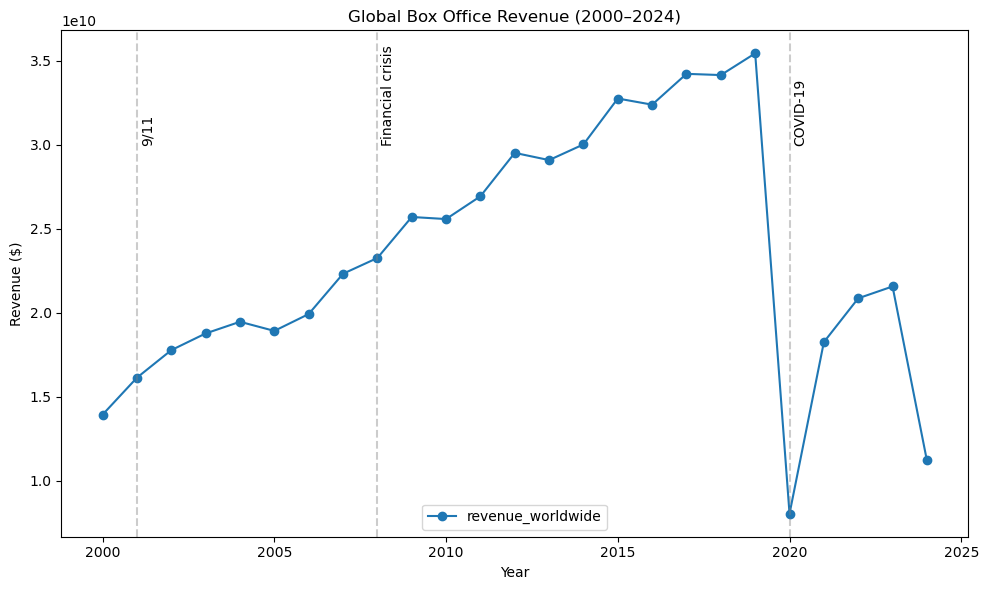

In [47]:
yr = df.groupby('release_year', as_index=False)['revenue_worldwide'].sum()
ax = yr.plot(x='release_year', y='revenue_worldwide', kind='line', figsize=(10,6), marker='o')
ax.set_title('Global Box Office Revenue (2000–2024)')
ax.set_xlabel('Year'); ax.set_ylabel('Revenue ($)')
for x,v in [(2001,'9/11'), (2008,'Financial crisis'), (2020,'COVID-19')]:
    ax.axvline(x,color='gray',ls='--',alpha=0.4); ax.text(x+0.1, yr['revenue_worldwide'].max()*0.85, v, rotation=90)
ax.figure.tight_layout(); ax.figure.savefig('global_revenue_timeline.png', dpi=220)


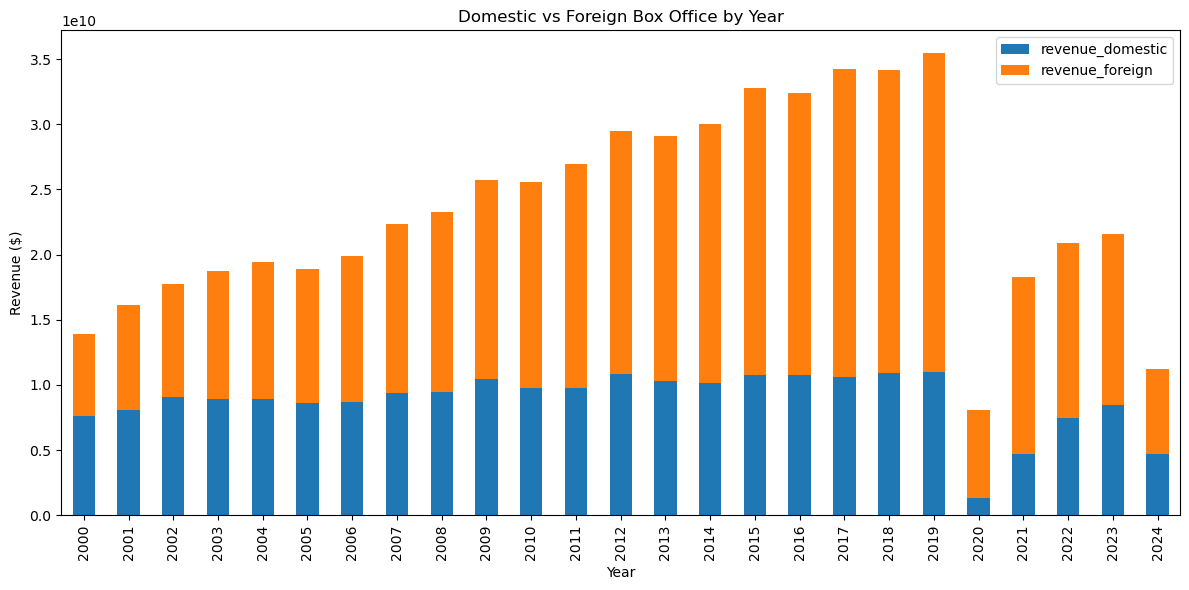

In [49]:
mix = df.groupby('release_year')[['revenue_domestic','revenue_foreign']].sum().reset_index()
ax = mix.set_index('release_year').plot(kind='bar', stacked=True, figsize=(12,6))
ax.set_title('Domestic vs Foreign Box Office by Year'); ax.set_xlabel('Year'); ax.set_ylabel('Revenue ($)')
ax.figure.tight_layout(); ax.figure.savefig('domestic_foreign_stack.png', dpi=220)


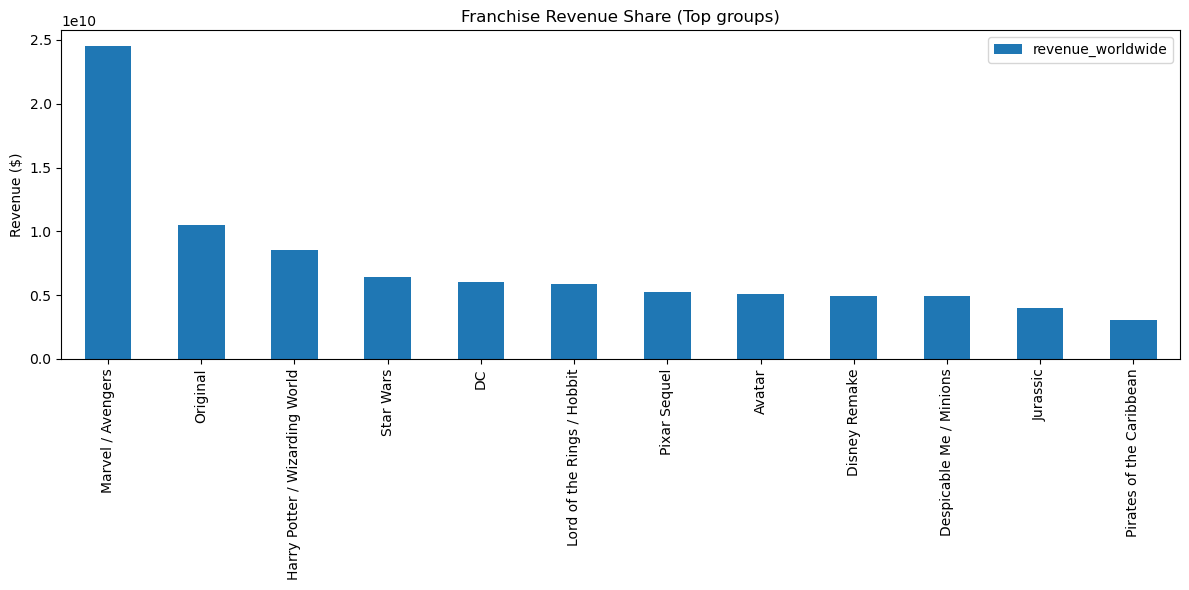

In [51]:
share = df_top.groupby('franchise', as_index=False)['revenue_worldwide'].sum()
share = share.sort_values('revenue_worldwide', ascending=False)
ax = share.head(12).plot(x='franchise', y='revenue_worldwide', kind='bar', figsize=(12,6))
ax.set_title('Franchise Revenue Share (Top groups)'); ax.set_xlabel(''); ax.set_ylabel('Revenue ($)')
ax.figure.tight_layout(); ax.figure.savefig('franchise_share_chart.png', dpi=220)


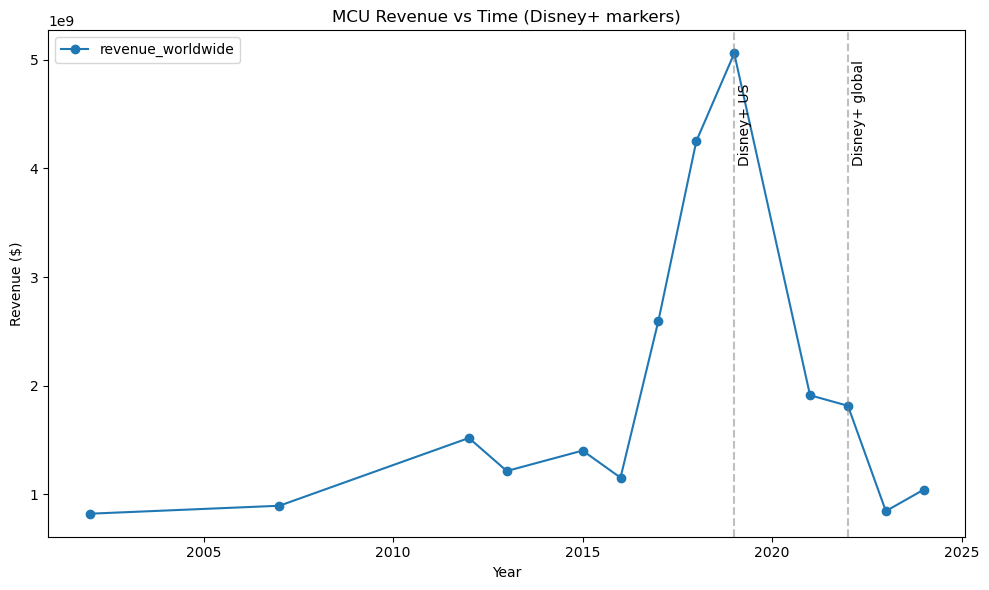

In [52]:
mcu = df_top[df_top['franchise'].str.contains('Marvel', na=False)].groupby('release_year', as_index=False)['revenue_worldwide'].sum()
ax = mcu.plot(x='release_year', y='revenue_worldwide', marker='o', figsize=(10,6))
ax.set_title('MCU Revenue vs Time (Disney+ markers)'); ax.set_xlabel('Year'); ax.set_ylabel('Revenue ($)')
for x,label in [(2019,'Disney+ US'), (2022,'Disney+ global')]:
    ax.axvline(x, color='gray', ls='--', alpha=0.5); ax.text(x+0.1, mcu['revenue_worldwide'].max()*0.8, label, rotation=90)
ax.figure.tight_layout(); ax.figure.savefig('mcu_decline_vs_streaming.png', dpi=220)


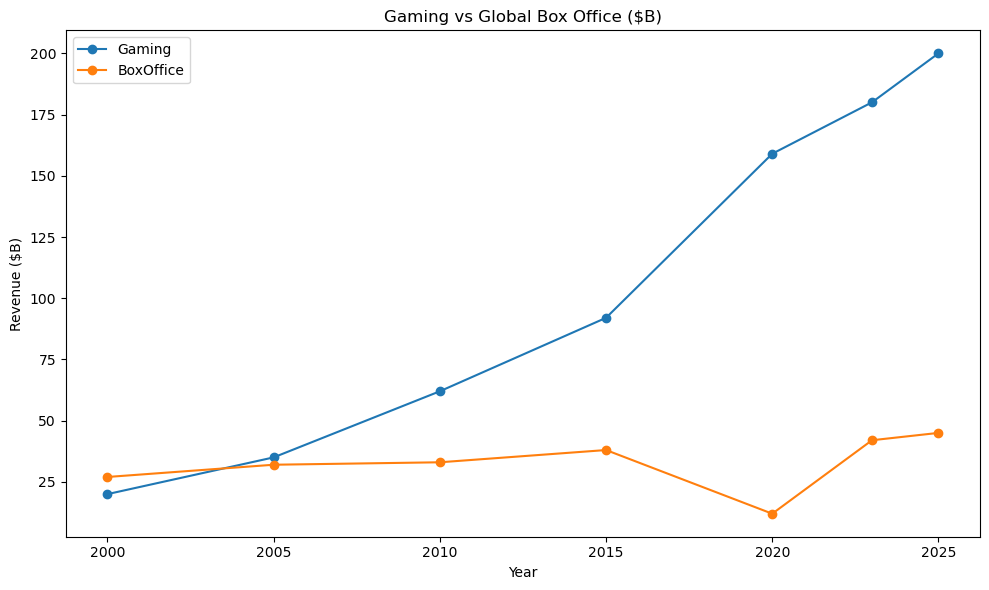

In [54]:
d = {'Year':[2000,2005,2010,2015,2020,2023,2025],
     'Gaming':[20,35,62,92,159,180,200],   # $B rough comps
     'BoxOffice':[27,32,33,38,12,42,45]}
g = pd.DataFrame(d)
ax = g.plot(x='Year', y=['Gaming','BoxOffice'], marker='o', figsize=(10,6))
ax.set_title('Gaming vs Global Box Office ($B)'); ax.set_ylabel('Revenue ($B)')
ax.figure.tight_layout(); ax.figure.savefig('gaming_vs_boxoffice.png', dpi=220)